In [11]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
from ultralytics import YOLO
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
from IPython.display import clear_output
import socket
import time
from datetime import datetime
import shutil
from random import randint
import re
import imagecodecs
import tifffile
from scipy.spatial import Voronoi, cKDTree
from matplotlib.path import Path
from rtree import index
from ctypes.wintypes import INT
import time
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

In [12]:
# Functions
idx = index.Index()

def sanitize_for_filesystem(input_string, len = 6):
    safe_string = re.sub(r'[^a-zA-Z0-9]', '', input_string)
    return safe_string[:len]

def save_tile_results(res2, save_path, max_tile_cols = 6, divider_width = 4, show=False):
    divider_color = (255, 0, 0)  # Divider color in RGB (red in this example)

    def calculate_canvas_size(images, max_cols, img_width, img_height, divider_width):
        #rows = (len(images) + max_cols - 1) // max_cols
        canvas_width = (img_width + divider_width) * min(len(images), max_cols) - divider_width
        canvas_height = (img_height * 2 + divider_width) #* rows - divider_width
        return canvas_width, canvas_height

    image_pairs = []

    for result in res2:
        img_orig = result.orig_img
        img_labeled = result.plot(labels=False, conf=False)
        img_orig_pil = Image.fromarray(img_orig)
        img_labeled_pil = Image.fromarray(img_labeled)
        image_pairs.append((img_orig_pil, img_labeled_pil))

    if not image_pairs:
        print("No images to display.")
    else:
        img_width, img_height = image_pairs[0][0].size
        canvas_width, canvas_height = calculate_canvas_size(image_pairs, max_tile_cols, img_width, img_height, divider_width)
        canvas = Image.new('RGB', (canvas_width, canvas_height), "white")
        draw = ImageDraw.Draw(canvas)

        for i, (img_orig, img_labeled) in enumerate(image_pairs[:max_tile_cols]):
            col = i % max_tile_cols; row = i // max_tile_cols
            top_left_x = col * (img_width + divider_width); top_left_y = row * (img_height * 2 + divider_width)
            canvas.paste(img_orig, (top_left_x, top_left_y))
            canvas.paste(img_labeled, (top_left_x, top_left_y + img_height + divider_width))

            # if col > 0:
            #     draw.line([(1+ top_left_x - divider_width, top_left_y), (1+top_left_x - divider_width, top_left_y + img_height * 2)], fill=divider_color, width=divider_width)
            #     draw.line([(0, top_left_y - divider_width), (canvas_width, top_left_y - divider_width)], fill=divider_color, width=divider_width)
        if (show): display(canvas)
        if (save_path!=""): canvas.save(save_path)

def results_toDF(res2, addIDCol = False):
    data = []
    for result in res2:
        boxes = result.boxes
        inst = 0
        for box in boxes:
            x, y, w, h = box.xywh[0].tolist()
            inst += 1
            data.append({
                'path': result.path,
                'Filename' : os.path.basename(result.path),
                'Instance' : inst,
                'Class': box.cls[0].item(),
                'Conf': box.conf[0].item(),
                'x': x, 'y': y,
                'w': w, 'h': h,
                'xc' : x + w/2,
                'yc' : y + h/2,
                'Circ Area' : (0.858 * w * h)
            })
    df = pd.DataFrame(data)
    if (addIDCol): 
        df['ID'] = df.groupby('path').cumcount()
    return df

def results_toCSV(res2, save_path):
    df = results_toDF(res2)
    df.to_csv(save_path, index=False)


def create_polygon_from_vertices(vertices):
            return Polygon(vertices)

# Function to find Voronoi region for a point
def find_voronoi_region(point, idx):
    point_geom = Point(point)
    for point_region_id in idx.intersection(point_geom.bounds):
        # Verify if point is actually in the Voronoi region
        if region_paths[point_region_id].contains_point(point):
            return point_region_id
    return -1

def is_point_in_ellipse(x, y, center_x, center_y, semi_major, semi_minor): ## calcualte the position of the point (trx) relative to ellipse center
    normalized_x = (x - center_x) / semi_major
    normalized_y = (y - center_y) / semi_minor
    return (normalized_x ** 2 + normalized_y ** 2) <= 1 ## if nx^2 + ny^2 <1, then point is within elliipse (is_within == True)

def save_tile_results(res2, save_path, max_tile_cols = 6, divider_width = 4, show=False):
    divider_color = (255, 0, 0)  # Divider color in RGB (red in this example)

    def calculate_canvas_size(images, max_cols, img_width, img_height, divider_width):
        #rows = (len(images) + max_cols - 1) // max_cols
        canvas_width = (img_width + divider_width) * min(len(images), max_cols) - divider_width
        canvas_height = (img_height * 2 + divider_width) #* rows - divider_width
        return canvas_width, canvas_height

    image_pairs = []

    for result in res2:
        img_orig = result.orig_img
        img_labeled = result.plot(labels=False, conf=False)
        img_orig_pil = Image.fromarray(img_orig)
        img_labeled_pil = Image.fromarray(img_labeled)
        image_pairs.append((img_orig_pil, img_labeled_pil))

    if not image_pairs:
        print("No images to display.")
    else:
        img_width, img_height = image_pairs[0][0].size
        canvas_width, canvas_height = calculate_canvas_size(image_pairs, max_tile_cols, img_width, img_height, divider_width)
        canvas = Image.new('RGB', (canvas_width, canvas_height), "white")
        draw = ImageDraw.Draw(canvas)

        for i, (img_orig, img_labeled) in enumerate(image_pairs[:max_tile_cols]):
            col = i % max_tile_cols; row = i // max_tile_cols
            top_left_x = col * (img_width + divider_width); top_left_y = row * (img_height * 2 + divider_width)
            canvas.paste(img_orig, (top_left_x, top_left_y))
            canvas.paste(img_labeled, (top_left_x, top_left_y + img_height + divider_width))

            # if col > 0:
            #     draw.line([(1+ top_left_x - divider_width, top_left_y), (1+top_left_x - divider_width, top_left_y + img_height * 2)], fill=divider_color, width=divider_width)
            #     draw.line([(0, top_left_y - divider_width), (canvas_width, top_left_y - divider_width)], fill=divider_color, width=divider_width)
        if (show): display(canvas)
        if (save_path!=""): canvas.save(save_path)

In [15]:
# Define datatset and base path
dataset = "Human Lung Cancer"
base_path = r"R:\FIVE\EXP\FIV925\Additional Datasets"
tile_base_path = r"S:\Phys\FIV925 XSection\Datasets\Additional Datasets"

# path for image
ome_tiff_path = f"{base_path}\\{dataset}\\morphology_mip.ome.tif"
preview_path = f"{base_path}\\{dataset}\\downsample.png"

# path for YOLO model
yolo_model_path = r"S:\Phys\FIV925 XSection\Datasets\Axons vs SCs\01i5\YO 384 0530 MAXI\map75=0855192 YOLOv8n-seg map75=081193 idx=4 ep=24 btch=32 rnd=2840511\weights\best.pt"
# r"S:\Phys\FIV925 XSection\Datasets\Axons vs SCs\01i3\M 384 MAXI 0213\0966245 idx=6 ep=98 mType=0 rnd=7669543\weights\best.pt"
# r"S:\Phys\FIV925 XSection\Datasets\Brain\01a\YO 384 0326 MAXI\map75=0650739 yolov9c  idx=12 ep=11 btch=8 rnd=6376250\weights\best.pt"
# r"S:\Phys\FIV925 XSection\Datasets\Axons vs SCs\01i5\YO 384 0530 MAXI\map75=0855192 YOLOv8n-seg map75=081193 idx=4 ep=24 btch=32 rnd=2840511\weights\best.pt"

# path for transcripts
transcripts = f"{base_path}\\{dataset}\\transcripts.csv"

# save path 
pred_save_path = f"{base_path}\\{dataset}\\results.csv"
tile_save_path = f"{tile_base_path}\\{dataset}"

# save tiles?
save_tiles = True

# conversion from um to pixel
um_to_pixel_div = 0.425 # divisor for um -> pixel conversion. 1 pixel = 0.425 um

# image level 
lvl = 1

# Optional:  define boundaries for cross section of interest (in pixel coord)
section_minx = 5427; section_maxx = 7027
section_miny = int(3000/um_to_pixel_div); section_maxy = int(8800/um_to_pixel_div)

(-0.5, 10616.5, 12048.5, -0.5)

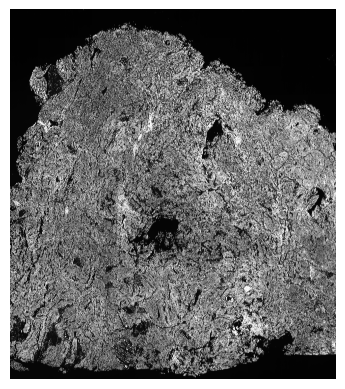

In [16]:
# For Human Lung Cancer
save_level = f"{base_path}\\{dataset}\\downsample.bmp"
with tifffile.TiffFile(ome_tiff_path) as tif:
    #full_size_image = tif.asarray() #If you want the full sized image
    # image = tif.asarray(series=0, level=1) # 27K x 21K
    image = tif.asarray() # 14K x 10K
    image_dapi = image[2,...]
    downsampled_image = image[::2, ::2] #1770 ish, very manageable
    # metadata = tif.ome_metadata

# what does sca mean?
sca = downsampled_image / np.quantile(downsampled_image,0.99) # rescale the intensity, if we use max it is way to far outside
sca[sca > 1] = 1
plt.imshow(sca, cmap='gray')
plt.axis('off')  # to hide axis labels and ticks

In [17]:
# infer
def results_toDF(res2, offset_x, offset_y, addIDCol = False):
    data = []
    for result in res2:
        boxes = result.boxes
        inst = 0
        for box in boxes:
            x, y, w, h = box.xywh[0].tolist()
            inst += 1
            data.append({
                'path': result.path,
                'Filename' : os.path.basename(result.path),
                'Instance' : inst,
                'Class': box.cls[0].item(),
                'Conf': box.conf[0].item(),
                'x': x, 'y': y,
                'w': w, 'h': h,
                'x_global': x + offset_x,
                'y_global': y + offset_y,
                'xc' : x + w/2,
                'yc' : y + h/2,
                'Circ Area' : (0.858 * w * h)
            })
    df = pd.DataFrame(data)
    if (addIDCol): 
        df['ID'] = df.groupby('path').cumcount()
    return df

iteration = 0
tile_size = 384
scale_factor = 1
tile_save_path = r"S:\Phys\FIV925 XSection\Datasets\Human Lung\Infer\Prediction Tiles"
save_tiles = False

df = pd.DataFrame()
model = YOLO(yolo_model_path)

tif = tifffile.TiffFile(ome_tiff_path)

# so this is an ndarray
#   (3000, 3200, 3)
#       wait, no, this was for the Colon Cancer data, but it wasn't working
# what do the numbers in the array represent?
#   i'm assuming each list of 3 is the RGB info
image = tif.asarray()

# image_dapi = image[2,:, :] # DAPI channel
#   I'm not sure if this is actually the DAPI channel

# what does this mean?
#   take every second row and column
# ok, so what's the image made of in the first place?
image_data = image[::2, ::2] # downsample by half

# normalize to 8 bit
max_val_16bit = np.max(image_data)
image_scaled = (image_data / max_val_16bit) * 255
image_8bit = image_scaled.astype(np.uint8)
#   wait, but the max value in image_data is 255, so isn't image_data already 8 bit?
#       it's 8 bits per channel, so 24 bit
#   bruh image_8bit and image_data are equal because image_data is already 8 bit

# create image and resize
og_image = Image.fromarray(image_8bit, 'L')
new_width = int(og_image.width * scale_factor); new_height = int(og_image.height * scale_factor)
image_resized = og_image.resize((new_width, new_height), Image.LANCZOS)
image = np.array(image_resized)

image_height, image_width = image_resized.size

for i in range(0, image_height, 384): # section_miny, section_maxy
    for j in range(0, image_width, 384): # section_minx, section_maxx
        tile = image[i:i+tile_size, j:j+tile_size]
        
        if tile.shape[0] == 0 or tile.shape[1] == 0:
            continue  # Skip tiles that have no width or height
        tile_as_img = Image.fromarray(tile, 'L')
        prediction = model.predict(tile_as_img, show=False, max_det=3000)
        iteration += 1
        print(iteration)

        # save out tile prediction
        if save_tiles:
            tile_path = os.path.join(tile_save_path, f"{i}_{j}.png")
            save_tile_results(prediction, tile_path, show=False)

        try: 
            temp_df = results_toDF(prediction, j, i, addIDCol=True)
            df = pd.concat([df, temp_df], ignore_index=True)
        except KeyError as e:
            print(f"Skipping iteration due to missing key: {e}")
            continue


0: 384x384 (no detections), 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 384)
1
Skipping iteration due to missing key: 'path'

0: 384x384 (no detections), 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 384)
2
Skipping iteration due to missing key: 'path'

0: 384x384 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 384)
3
Skipping iteration due to missing key: 'path'

0: 384x384 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 384)
4
Skipping iteration due to missing key: 'path'

0: 384x384 (no detections), 10.0ms
Speed: 4.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 384)
5
Skipping iteration due to missing key: 'path'

0: 384x384 (no detections), 11.0ms
Speed: 4.0ms preprocess, 11.0ms inference, 0.0ms postproces

In [ ]:
# how I would export the data
df.to_csv(r"R:\FIVE\EXP\FIV925\Additional Datasets\Human Lung Cancer\results_3.csv")